Using device: cuda
Loading Validation Data...
Loading Model from resnet50_stanford_cars.pth...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13268\1698763001.py:123: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location

Running Inference...

       TEST RESULTS       
Overall Accuracy: 76.18%

Generating Detailed Report...

--- Top 5 Best Classified Cars ---
     precision  recall  f1-score  support
156        1.0     1.0       1.0      7.0
115        1.0     1.0       1.0      8.0
107        1.0     1.0       1.0      9.0
108        1.0     1.0       1.0      9.0
98         1.0     1.0       1.0      5.0

--- Top 5 Worst Classified Cars ---
    precision    recall  f1-score  support
13   0.142857  0.111111  0.125000      9.0
36   0.400000  0.250000  0.307692      8.0
34   0.666667  0.250000  0.363636      8.0
22   0.666667  0.250000  0.363636      8.0
82   0.375000  0.375000  0.375000      8.0

Generating Confusion Matrix (First 20 classes)...


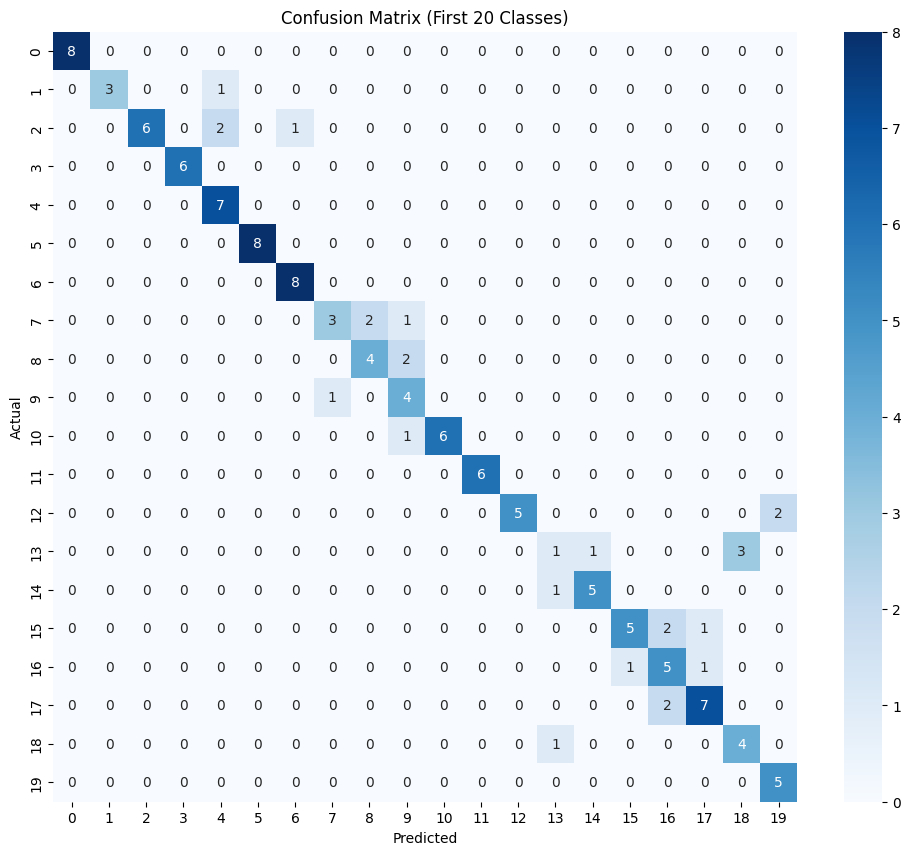


Calculating ROC & AUC...


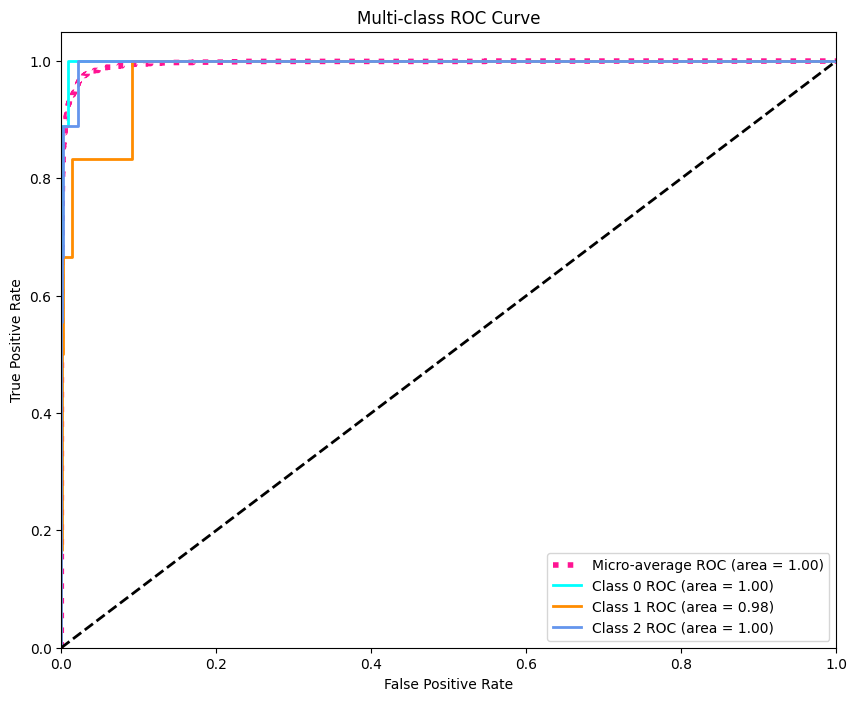

In [4]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from PIL import Image
from itertools import cycle

# ==========================================
# 1. SETUP: DATASET & MODEL DEFINITION
# (Must match Training script exactly)
# ==========================================

class StanfordCarsDataset(Dataset):
    def __init__(self, root_dir, mat_file, image_folder, transform=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.transform = transform
        self.annotations = scipy.io.loadmat(mat_file)
        raw_samples = self.annotations['annotations'][0]
        
        # Filtering logic (Must match training)
        self.samples = []
        for sample in raw_samples:
            img_name = sample[-1][0]
            img_path = os.path.join(self.root_dir, self.image_folder, img_name)
            if os.path.exists(img_path):
                self.samples.append(sample)
                
        self.classes = [str(i) for i in range(196)] 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ann = self.samples[idx]
        img_name = ann[-1][0] 
        label = ann[-2][0][0] - 1  
        img_path = os.path.join(self.root_dir, self.image_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

def get_resnet_model(num_classes=196):
    # Load architecture without weights
    model = models.resnet50(weights=None) 
    
    # Re-create the head (MATCHING THE NEW TRAINING CONFIG)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 1024), # Updated to 1024
        nn.ReLU(),
        nn.Dropout(0.5),              # Updated to 0.5
        nn.Linear(1024, num_classes)  # Updated to 1024
    )
    return model

def get_validation_loader(data_root, batch_size=32):
    # Standard ImageNet normalization
    stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    valid_tfms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(*stats)
    ])

    # Path logic (Robust check)
    possible_paths = [
        os.path.join(data_root, 'car_devkit', 'devkit', 'cars_train_annos.mat'),
        os.path.join(data_root, 'car_devkit', 'cars_train_annos.mat'),
        os.path.join(data_root, 'cars_train_annos.mat')
    ]
    mat_path = next((p for p in possible_paths if os.path.exists(p)), None)
    
    if not mat_path:
        raise FileNotFoundError("Could not find annotation .mat file.")

    full_dataset = StanfordCarsDataset(
        root_dir=data_root, 
        mat_file=mat_path,
        image_folder=r'cars_train/cars_train', # Ensure this matches your folder structure
        transform=valid_tfms 
    )

    # Re-create split with random_state=42 to get the SAME validation set as training
    labels = [full_dataset.samples[i][-2][0][0] for i in range(len(full_dataset))]
    _, val_indices = train_test_split(
        range(len(full_dataset)), 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    val_set = torch.utils.data.Subset(full_dataset, val_indices)
    return DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

# ==========================================
# 2. EVALUATION LOGIC
# ==========================================

def evaluate_model(model_path, data_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1. Load Data
    print("Loading Validation Data...")
    val_loader = get_validation_loader(data_path)
    
    # 2. Load Model
    print(f"Loading Model from {model_path}...")
    model = get_resnet_model(num_classes=196)
    
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except Exception as e:
        print(f"Error loading model weights: {e}")
        return

    model.to(device)
    model.eval()

    # 3. Inference Loop
    print("Running Inference...")
    all_preds = []
    all_labels = []
    all_probs = [] 

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1) 
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # 4. Metrics & Visualization
    print("\n" + "="*30)
    print("       TEST RESULTS       ")
    print("="*30)

    # --- Accuracy ---
    acc = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {acc*100:.2f}%")

    # --- Classification Report (Pandas Version) ---
    print("\nGenerating Detailed Report...")
    report_dict = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).transpose()
    
    # Print Top 10 Best Classes (by F1-score)
    print("\n--- Top 5 Best Classified Cars ---")
    print(report_df.sort_values(by='f1-score', ascending=False).head(5))

    # Print Top 10 Worst Classes
    print("\n--- Top 5 Worst Classified Cars ---")
    # Exclude the average rows
    classes_only = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
    print(classes_only.sort_values(by='f1-score', ascending=True).head(5))

    # --- Confusion Matrix ---
    print("\nGenerating Confusion Matrix (First 20 classes)...")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm[:20, :20], annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix (First 20 Classes)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # --- ROC & AUC (One-vs-Rest) ---
    print("\nCalculating ROC & AUC...")
    y_test_bin = label_binarize(all_labels, classes=range(196))
    n_classes = y_test_bin.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate for all classes
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    # Plot 3 random classes
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(3), colors): 
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} ROC (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# ==========================================
# 3. RUN EVALUATION
# ==========================================

# CONFIGURATION
MODEL_PATH = "resnet50_stanford_cars.pth" 
DATA_PATH = r"D:/deep_learning/stanford-cars-dataset" 

if __name__ == "__main__":
    if os.path.exists(MODEL_PATH) and os.path.exists(DATA_PATH):
        evaluate_model(MODEL_PATH, DATA_PATH)
    else:
        print("Error: Could not find model or dataset path.")
        print(f"Checking Model: {MODEL_PATH} -> {os.path.exists(MODEL_PATH)}")
        print(f"Checking Data: {DATA_PATH} -> {os.path.exists(DATA_PATH)}")